In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

In [2]:
rng = np.random.default_rng(344)

In [10]:
def simulationBD(params, n, tmax, ts, plot=False, plotShow=True, initial_state=0):
    '''
    Simulate a sample path of the birth death model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x = path[-1]

        # transition rates
        q_tx = params['k_tx']
        q_deg = x * params['k_deg']
        q_hold = q_tx + q_deg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2]
        prob = [
            q_tx / q_hold,
            q_deg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append(x + 1)
            case 2:
                path.append(x - 1)

    # create step function of sample path from jump times and jump values
    path_function = scipy.interpolate.interp1d(jump_times, path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    samples = path_function(sample_times)
    samples = [int(x) for x in samples]

    # plot sample path
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, path_function(x), label="Sample path")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Count")
        plt.legend()
        if plotShow: plt.show()

    return samples

In [11]:
def simulationBDInt(params, n, tmax, ts, plot=False, plotShow=True, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death interaction model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path")
        plt.plot(x, x2_path_function(x), label="X2 sample path")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Count")
        plt.legend()
        if plotShow: plt.show()

    return samples

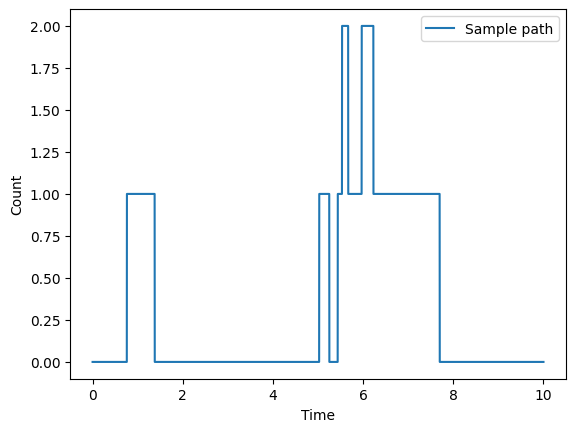

In [14]:
params_BD = {
    'k_tx': 1,
    'k_deg': 1
}

sample_BD = simulationBD(params_BD, n=1, tmax=10, ts=10, plot=True)

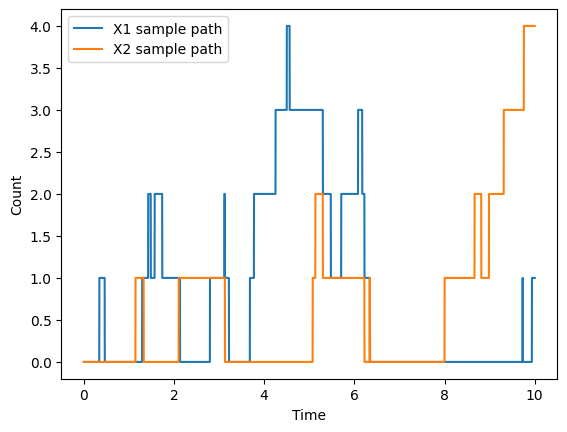

In [15]:
params_BDInt = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

sample_BDInt = simulationBDInt(params_BDInt, n=1, tmax=10, ts=10, plot=True)

# Simulation of realistic parameters

Developing and testing inference methods in 'birth-death-interaction', 'telegraph-interaction' and 'cross-model-interaction' we have so far manuallly chosen parameter values used to simulate data: setting all to 1, or varying transcription rates or gene on / off rates.

However, to understand how the methods will perform on real data (and how performance could be improved) we now focus on simulating realistic parameters which can then be used to simulate realistic data, emulating the data observed by real experiments.

## Poisson model of mRNA

We begin by considering a poisson model of mRNA counts (birth-death) and estimate the parameter ranges when fitting to observed data.

From https://www.nature.com/articles/nature10098 the half-lives of mRNA are observed $ \in (10^{0}, 10^{1.5})$ which are related to their degradation rate $k_{deg}$ by: $t_{1/2} = \frac{ln(2)}{k_{deg}}$, resulting in *approximately* $log(k_{deg}) \in (-1.5, 0)$.

The mean of observed mRNA counts is $ \in (10^{-2}, 10^{2}) $ and following the model, the mean of observed counts is $ \frac{k_{tx} \mathbb{E}[\beta]}{k_{deg}}$, so combining with the range of degradation rates results in *approximately* $log(k_{tx} \mathbb{E}[\beta]) \in (-3, 2) $.

We assume that the log-rates are uniformly distributed over these ranges (although the half lives may follow a more normal-like distribution).

## Capture efficiency

Using data to estimate capture efficiency (VASA-seq data) by normalising total transcript counts per cell to have a mean of 0.06 and fitting a Beta distribution results in the *approximate* values of $\beta = 20$ and $\alpha=1$ (which can be changed to vary the mean capture efficiency of $\frac{\alpha}{\alpha + \beta}$ which is 0.05 for the values provided (almost 0.06))

## Simulation process

### Individual genes

- Sample $ log(k_{tx} \mathbb{E}[\beta]) \sim \text{Unif}(-3, 2) $ and $ log(k_{deg}) \sim \text{Unif}(-1.5, 0) $
- Exponentiate and scale by mean capture efficiency $ \mathbb{E} = 0.06 $ to get $k_{tx}$ and $k_{deg}$ values
- Sample capture efficiency $\beta_{j}$ for each cell $j$ from beta distribution
- Simulate data using reaction rates, downscale using capture efficiency

### Interacting pair of genes

- Sample transcription and degradation rates for each gene as before
- Sample capture efficiency for each cell as before
- Choose a value of $k_{reg}$

However, note that the 'strength' of interaction depends on the magnitude of $k_{reg}$ *relative* to the other parameters: it will be much easier to detect interaction in data simulated using $k_{reg} = 0.1$ if the other rates are of magnitude $0.01$ (as then equivalent to a value of 10 relative to other rates of 1) compared to if the other rates are of magnitude $10$ (as then equivalent to a value of 0.01 relative to other rates of 1)

# Simulation: individual genes

Text(0, 0.0, 'Beta = 20')

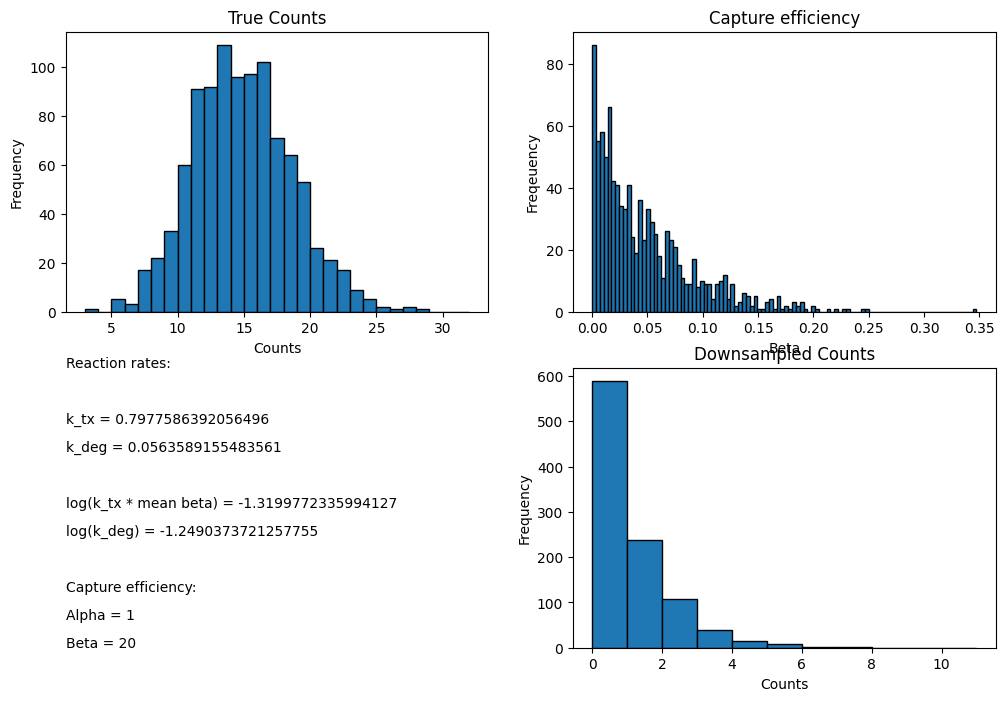

In [150]:
# sample size (cells)
n = 1000

# sample rates from log-uniform distribution
log_k_tx_beta = rng.uniform(-3, 2)
log_k_deg = rng.uniform(-1.5, 0)

# exponentiate and scale
k_tx = (10 ** log_k_tx_beta) / 0.06
k_deg = 10 ** log_k_deg

# sample counts from stationary distribution
sample = rng.poisson(lam=k_tx / k_deg, size=n)

# plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].hist(sample, bins=range(int(np.min(sample)), int(np.max(sample)) + 5), edgecolor='black');
axs[0, 0].set_xlabel("Counts")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_title("True Counts")

# sample capture efficiency from beta distribution
beta = rng.beta(a=1, b=20, size=n)

# plot
axs[0, 1].hist(beta, bins=100, edgecolor='black');
axs[0, 1].set_xlabel("Beta")
axs[0, 1].set_ylabel("Freqeuency")
axs[0, 1].set_title("Capture efficiency")

# downsample counts using capture efficiency
sample_downsampled = rng.binomial(sample, beta)

# plot
axs[1, 1].hist(sample_downsampled, bins=range(int(np.min(sample_downsampled)), int(np.max(sample_downsampled)) + 5), edgecolor='black');
axs[1, 1].set_xlabel("Counts")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("Downsampled Counts")

# display info
axs[1, 0].axis('off')
axs[1, 0].text(0, 1.0, f"Reaction rates:")
axs[1, 0].text(0, 0.8, f"k_tx = {k_tx}")
axs[1, 0].text(0, 0.7, f"k_deg = {k_deg}")
axs[1, 0].text(0, 0.5, f"log(k_tx * mean beta) = {log_k_tx_beta}")
axs[1, 0].text(0, 0.4, f"log(k_deg) = {log_k_deg}")
axs[1, 0].text(0, 0.2, f"Capture efficiency:")
axs[1, 0].text(0, 0.1, f"Alpha = 1")
axs[1, 0].text(0, 0.0, f"Beta = 20")

# Simulation: interacting pair of genes

k_tx_1 = 9.564702884961067
k_tx_2 = 1.365128916000253
k_deg_1 = 0.7968096263246749
k_deg_2 = 0.2610588522661454
k_reg = 0.2610588522661454


Text(0, 0.0, 'Beta = 20')

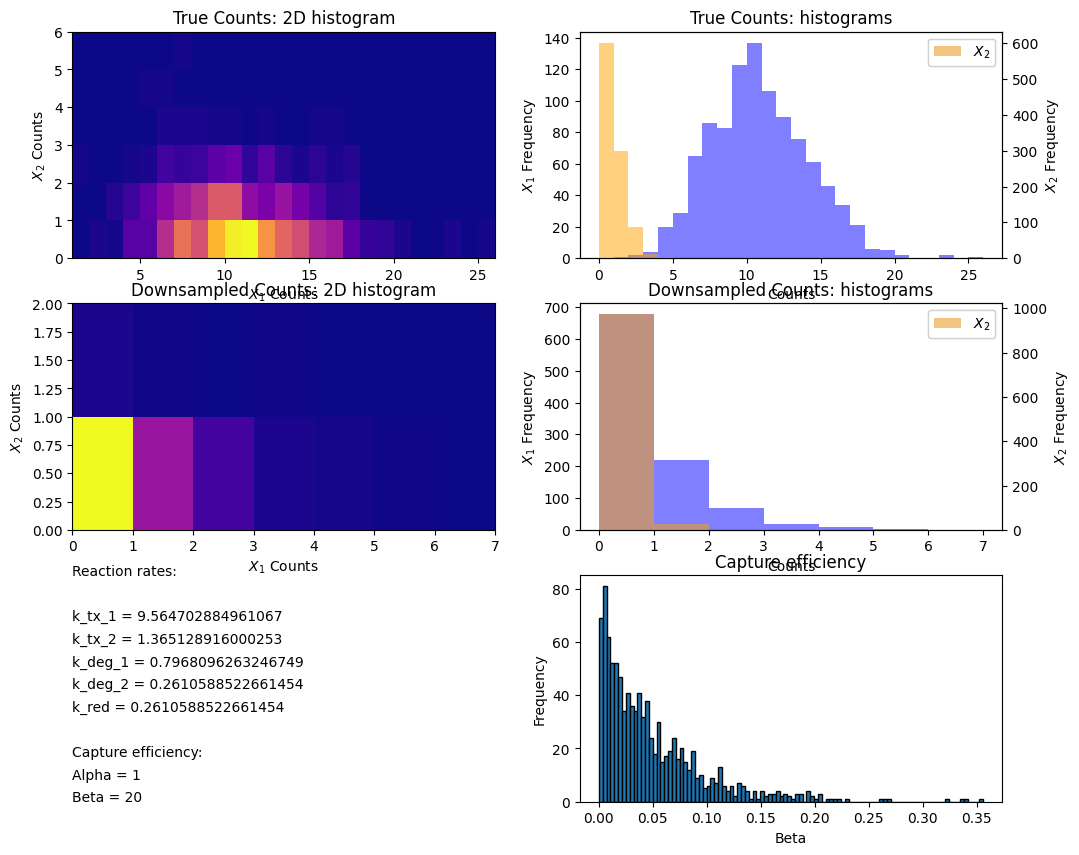

In [80]:
# sample size (cells)
n = 1000

# simulation parameters
params = {}

# sample rates from log-uniform distribution for both genes
log_k_tx_beta_1 = rng.uniform(-3, 2)
log_k_tx_beta_2 = rng.uniform(-3, 2)
log_k_deg_1 = rng.uniform(-1.5, 0)
log_k_deg_2 = rng.uniform(-1.5, 0)

# exponentiate and scale
params['k_tx_1'] = (10 ** log_k_tx_beta_1) / 0.06
params['k_tx_2'] = (10 ** log_k_tx_beta_2) / 0.06
params['k_deg_1'] = 10 ** log_k_deg_1
params['k_deg_2'] = 10 ** log_k_deg_2

# select interaction strength: relative to degradation rate
params['k_reg'] = 1 * params['k_deg_2']

for key, val in params.items():
    print(f"{key} = {val}")

# sample counts from stationary distribution
sample = simulationBDInt(params, n=n, tmax=100, ts=10) 

x1_sample = [x[0] for x in sample]
x2_sample = [x[1] for x in sample]

# plot

# 2D histogram of true counts
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs[0, 0].hist2d(x1_sample, x2_sample, bins=[range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2)],
                 cmap='plasma')
axs[0, 0].set_xlabel(r"$X_{1}$ Counts")
axs[0, 0].set_ylabel(r"$X_{2}$ Counts")
axs[0, 0].set_title("True Counts: 2D histogram")

# separate histograms of observed counts
axs[0, 1].hist(x1_sample, bins=range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), alpha=0.5, color="blue", label=r"$X_{1}$");
axs01_twin = axs[0, 1].twinx()
axs01_twin.hist(x2_sample, bins=range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2), alpha=0.5, color="orange", label=r"$X_{2}$");
axs[0, 1].set_xlabel("Counts")
axs[0, 1].set_ylabel(r"$X_{1}$ Frequency")
axs01_twin.set_ylabel(r"$X_{2}$ Frequency")
axs[0, 1].set_title("True Counts: histograms")
axs[0, 1].legend()
axs01_twin.legend()

# sample capture efficiency from beta distribution
beta = rng.beta(a=1, b=20, size=n)

# downsample counts using capture efficiency
x1_sample_downsampled = rng.binomial(x1_sample, beta).tolist()
x2_sample_downsampled = rng.binomial(x2_sample, beta).tolist()
sample_downsampled = list(zip(x1_sample_downsampled, x2_sample_downsampled))

# 2D histogram of downsampled counts
axs[1, 0].hist2d(x1_sample_downsampled, x2_sample_downsampled, bins=[range(int(np.min(x1_sample_downsampled)), int(np.max(x1_sample_downsampled)) + 2), range(int(np.min(x2_sample_downsampled)), int(np.max(x2_sample_downsampled)) + 2)],
                 cmap='plasma')
axs[1, 0].set_xlabel(r"$X_{1}$ Counts")
axs[1, 0].set_ylabel(r"$X_{2}$ Counts")
axs[1, 0].set_title("Downsampled Counts: 2D histogram")

# separate histograms of downsampled counts
axs[1, 1].hist(x1_sample_downsampled, bins=range(int(np.min(x1_sample_downsampled)), int(np.max(x1_sample_downsampled)) + 2), alpha=0.5, color="blue", label=r"$X_{1}$");
axs11_twin = axs[1, 1].twinx()
axs11_twin.hist(x2_sample_downsampled, bins=range(int(np.min(x2_sample_downsampled)), int(np.max(x2_sample_downsampled)) + 2), alpha=0.5, color="orange", label=r"$X_{2}$");
axs[1, 1].set_xlabel("Counts")
axs[1, 1].set_ylabel(r"$X_{1}$ Frequency")
axs11_twin.set_ylabel(r"$X_{2}$ Frequency")
axs[1, 1].set_title("Downsampled Counts: histograms")
axs[1, 1].legend()
axs11_twin.legend()

# capture efficiency
axs[2, 1].hist(beta, bins=100, edgecolor='black');
axs[2, 1].set_xlabel("Beta")
axs[2, 1].set_ylabel("Frequency")
axs[2, 1].set_title("Capture efficiency")

# display info
axs[2, 0].axis('off')
axs[2, 0].text(0, 1.0, f"Reaction rates:")
axs[2, 0].text(0, 0.8, f"k_tx_1 = {params['k_tx_1']}")
axs[2, 0].text(0, 0.7, f"k_tx_2 = {params['k_tx_2']}")
axs[2, 0].text(0, 0.6, f"k_deg_1 = {params['k_deg_1']}")
axs[2, 0].text(0, 0.5, f"k_deg_2 = {params['k_deg_2']}")
axs[2, 0].text(0, 0.4, f"k_red = {params['k_reg']}")
axs[2, 0].text(0, 0.2, f"Capture efficiency:")
axs[2, 0].text(0, 0.1, f"Alpha = 1")
axs[2, 0].text(0, 0.0, f"Beta = 20")

# Bootstrap and Simulation code: pairs of genes

Modify bootstrap to compute 'box-truncation' of observed counts based on threshold

In [3]:
def simulation_B(params, n, beta, tmax, ts, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    beta: capture efficiency, list of length n (per cell) or single value
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)

    # convert to integers
    x1_samples = [int(x1) for x1 in x1_samples]
    x2_samples = [int(x2) for x2 in x2_samples]

    # apply capture efficiency: for each count, draw from Binomial(count, beta)
    x1_samples_beta = np.random.binomial(x1_samples, beta).tolist()
    x2_samples_beta = np.random.binomial(x2_samples, beta).tolist()

    # re-combine to pairs of samples
    samples = list(zip(x1_samples, x2_samples))
    samples_beta = list(zip(x1_samples_beta, x2_samples_beta))

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Counts")
        plt.legend()
        plt.show()

    # collect all sample paths: original and observed
    data = {
        'x1_OG': x1_samples,
        'x2_OG': x2_samples,
        'OG': samples,
        'x1_OB': x1_samples_beta,
        'x2_OB': x2_samples_beta,
        'OB': samples_beta
    }

    return data

In [4]:
def bootstrap_B(data, n=1000, BS=1000, beta=None, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0)):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    simulating sample path and computing empirical distribution over 
    several bootstrap samples OR using provided sample

    data: dict of reaction rate constants to simulate OR sample
    n: number of samples from stationary distribution
    BS: number of bootstrap resamples
    beta: capture efficiency, list of length n (per cell) or single value
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''
    if type(data) == dict:
        # simulate n samples from stationary distribution
        samples = simulation_B(params, n, beta, tmax, ts, plot=False, initial_state=initial_state)

        # compute maximum x1 and x2 values
        M = int(np.max(samples['x1_OB']))
        N = int(np.max(samples['x2_OB']))

        # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
        integer_samples = [sample[1] + (N + 1)*sample[0] for sample in samples['OB']]

    else:
        # sample provided
        samples = data

        # sample size
        n = len(samples)

        # compute maximum x1 and x2 values
        M, N = np.max(samples, axis = 0)
        M, N = int(M), int(N)

        # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
        integer_samples = [sample[1] + (N + 1)*sample[0] for sample in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(BS, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(BS)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=BS*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # compute 2.5% and 97.5% quantiles for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # set truncation bounds
    m_OB, n_OB, M_OB, N_OB = M, N, 0, 0

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            # below: replace
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]
            # above: update truncation
            else:
                # check if smaller than current min
                if x1 < m_OB:
                    m_OB = x1
                if x2 < n_OB:
                    n_OB = x2
                # check if larger than current max
                if x1 > M_OB:
                    M_OB = x1
                if x2 > N_OB:
                    N_OB = x2

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                # within truncation: green CI lines
                if (x1 >= m_OB) and (x2 >= n_OB) and (x1 <= M_OB) and (x2 <= N_OB):
                    color = "green"
                else:
                    color = "red"
                axs[x1, x2].hist(counts[:, x1, x2]);
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color=color)
                axs[x1, x2].axvline(bounds[1, x1, x2], color=color)

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

    if printing:
        print(f"Box truncation: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}]")

    results =  {
        'samples': samples,
        'sample_counts': sample_counts,
        'joint': bounds,
        'm_OB': m_OB,
        'n_OB': n_OB,
        'M_OB': M_OB,
        'N_OB': N_OB
    }

    return results

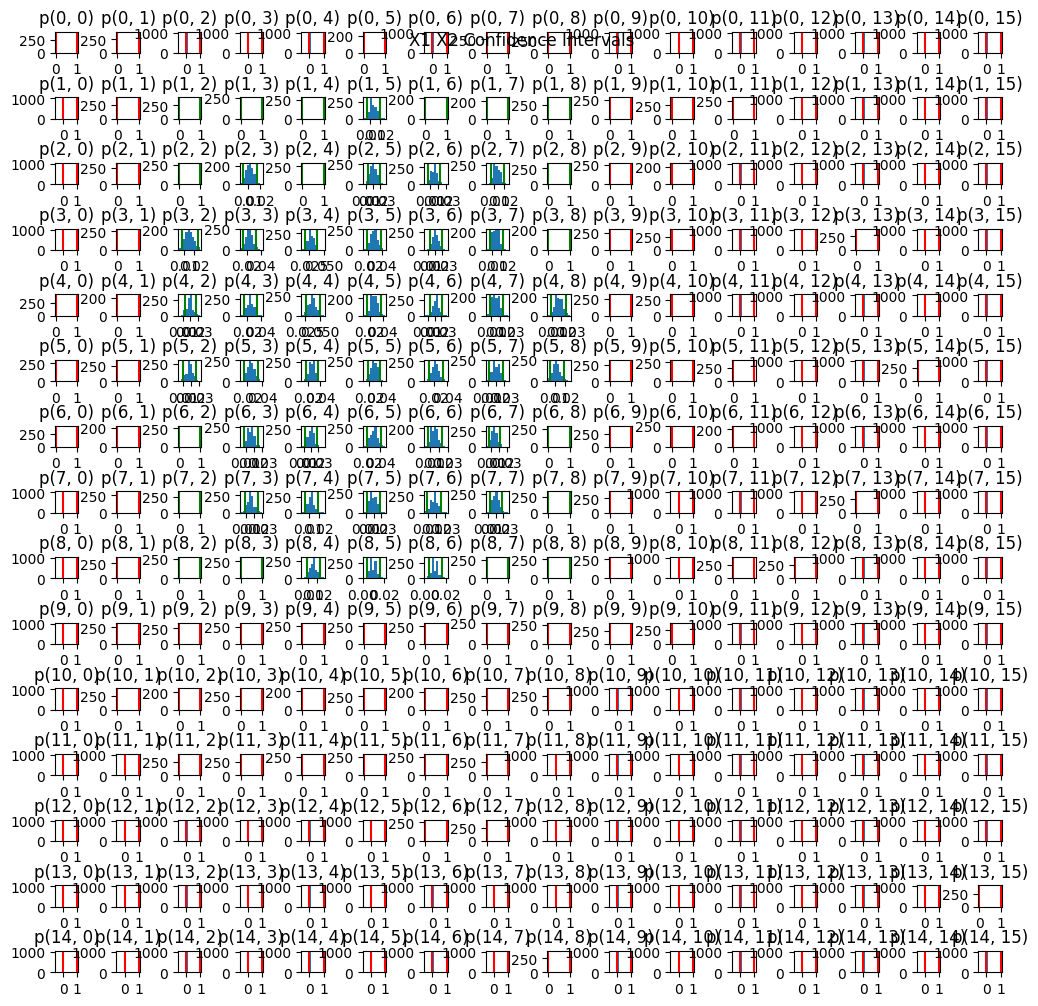

In [35]:
# set test parameters
params = {
    'k_tx_1': 5,
    'k_tx_2': 5,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}
beta = np.array([1.0 for j in range(1000)])

# bootstrap and plot: see truncation box in green
bounds = bootstrap_B(params, n=1000, BS=1000, beta=beta, tmax=100, ts=10, thresh=10, plot=True)

# Optimization code: detecting interaction

Add support for the new 'box-truncation' for observed counts

In [5]:
def B(x1_OB, x2_OB, x1_OG, x2_OG, beta):
    '''Compute (1 / n) sum j = 1 to n of P(X1_OB, X2_OB | X1_OG, X2_OG, Beta_j): product of binomials.'''

    val = 0.0

    # compute binomial probability
    if (x1_OB <= x1_OG) and (x2_OB <= x2_OG):

        bin_coef_x1 = scipy.special.comb(x1_OG, x1_OB)
        bin_coef_x2 = scipy.special.comb(x2_OG, x2_OB)

        for beta_j in beta:

            p1 = beta_j**x1_OB * (1 - beta_j)**(x1_OG - x1_OB)
            p2 = beta_j**x2_OB * (1 - beta_j)**(x2_OG - x2_OB)
            val += p1 * p2

        n = beta.shape[0]
        val = float(bin_coef_x1 * bin_coef_x2 * val / n)

        return val
    
    # asssume we cannot observe more counts than are present originally
    else:
        return val

In [6]:
def findTrunc(x1_OB, x2_OB, beta, thresh):
    '''
    Return the first pair of states (x1_OG, x2_OG) which
    have B(x1_OB, x2_OB, x1_OG, x2_OG, beta) < thresh
    '''

    x1_OG, x2_OG = x1_OB, x2_OB
    bp = 1
    while bp > thresh:
        
        # increment
        x1_OG += 1
        x2_OG += 1

        # compute
        bp = B(x1_OB, x2_OB, x1_OG, x2_OG, beta)

    return x1_OG, x2_OG

In [7]:
def preComputeTruncation(M, N, beta, thresh):
    '''
    Compute M x N original truncations

    M, N: shape of observed pairs that truncations are computed for
    beta: capture efficiency vector
    thresh: threshold for trunction
    '''
    truncations = {}
    for x1_OB in range(M):
        truncations[x1_OB] = {}
        for x2_OB in range(N):
            x1_OG, x2_OG = findTrunc(x1_OB, x2_OB, beta, thresh)
            truncations[x1_OB][x2_OB] = (x1_OG, x2_OG)

    return truncations

## Code: minimization

In [8]:
def optimization_min(params, bounds, beta, truncations, K=100, silent=True,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=300, BestBdThresh=0.0001):
    '''
    Minimize k_reg subject to constraints, terminating early if non-zero lower
    bound is obtained

    params: dictionary of reaction rate constants, keys should be afixed value,
            "v" for variable, "vo" for variable to optimize
    bounds: contains 2 x M x N array of confidence interval bounds on stat. dist. of system
            and observed truncation information
    beta: capture efficiency vector
    truncations: pre-computed original truncations

    K: fixed upper bound on reaction rate constants
    silent: toggle printing of optimization status
    print_solution: toggle for printing optimization solution
    print_truncation: toggle for printing truncation information
    thresh_trunc: threshold on B coefficients for original truncation
    MIPGap: GUROBI parameter
    time_limit: time limit on optimization before termination (5 min default)
    BestBdThresh: size of non-zero lower bound on k_reg needed to terminate early
    '''

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # optimization settings
    md.Params.MIPGap = MIPGap

    '''experimental'''
    # aggressive presolve
    md.Params.Presolve = 2
    # focus on lower bound of objective: allows early termination
    md.Params.MIPFocus = 3

    # set threshold on BestBd for termination
    md.Params.BestBdStop = BestBdThresh

    # State space truncations

    # observed truncations: computed during bootstrap
    m_OB = bounds['m_OB']
    n_OB = bounds['n_OB']
    M_OB = bounds['M_OB']
    N_OB = bounds['N_OB']

    # find largest original truncations: (pre)computed by thresholding coefficients
    M_OG, N_OG = 0, 0
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            try:
                # lookup
                m_OG, n_OG = truncations[x1_OB][x2_OB]
            except KeyError:
                # compute if not available
                m_OG, n_OG = findTrunc(x1_OB, x2_OB, beta, thresh_trunc)
                # store
                truncations[x1_OB][x2_OB] = (m_OG, n_OG)

            # update largest values
            if m_OG > M_OG:
                M_OG = m_OG
            if n_OG > N_OG:
                N_OG = n_OG

    if print_truncation:
        print(f"Observed counts: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}] \nOriginal counts: [0, {M_OG - 1}] x [0, {N_OG - 1}]")

    # variables

    # stationary distribution: original counts
    p = md.addMVar(shape=(M_OG, N_OG), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # stationary distribution bounds: for each observed count
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):

            # individual truncation: lookup from pre-computed dict
            m_OG, n_OG = truncations[x1_OB][x2_OB]

            sum_expr = gp.quicksum([B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p[x1_OG, x2_OG] for x1_OG in range(m_OG) for x2_OG in range(n_OG)])
            md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB], name=f"B lb {x1_OB}, {x2_OB}")
            md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1_OG in range(M_OG - 1):
        for x2_OG in range(N_OG - 1):
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                # remove terms when x1 or x2 = 0 since not in equation
                # so multiply by toggle
                rates['k_tx_1'] * x1_zero * p[x1_OG - 1, x2_OG] + \
                rates['k_tx_2'] * x2_zero * p[x1_OG, x2_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
                rates['k_deg_2'] * (x2_OG + 1) * p[x1_OG, x2_OG + 1] + \
                rates['k_reg'] * (x1_OG + 1) * (x2_OG + 1) * p[x1_OG + 1, x2_OG + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                 rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG + \
                 rates['k_reg'] * x1_OG * x2_OG) * p[x1_OG, x2_OG] == 0,
                name=f"Equation {x1_OG}, {x2_OG}"
                )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'k_tx_1': params['k_tx_1'],
        'k_tx_2': params['k_tx_2'],
        'k_deg_1': params['k_deg_1'],
        'k_deg_2': params['k_deg_2'],
        'k_reg': None
    }

    # Optimize

    # set objective: minimize interaction parameter
    md.setObjective(rates['k_reg'], GRB.MINIMIZE)

    # attempt to optimize
    try:
        md.optimize()
        min_val = md.ObjVal
    except:
        min_val = None

    # report status
    status_min = status_codes[md.status]

    # record
    solution['k_reg'] = [min_val, status_min]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'k_reg':    
                print(f"{key} lower bound {val[0]}, status {val[1]}")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

## Code: hypothesis

In [9]:
def optimization_B_hyp(params, bounds, beta, truncations, K=100, silent=True,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=300):
    '''
    Feasibility test under assumption of no interaction: k_reg = 0

    params: dictionary of reaction rate constants
            fixed value, "v" for variable, "vo" for variable to optimize
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    beta: capture efficiency
    truncations: pre-computed threshold truncations on original counts
    
    K: fixed upper bound on reaction rate constants
    silent: toggle printing of optimization status
    print_solution: toggle for printing optimization solution
    print_truncation: toggle for printing truncations used
    thresh_trunc: threshold on B coefficients for original truncation
    time_limit: limit on optimization time before termination
    '''

    # create model
    md = gp.Model('birth-death-regulation-capture-efficiency-hyp')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set time limit: 5 minute default
    md.Params.TimeLimit = time_limit

    # State space truncations

    # observed truncations: computed during bootstrap
    m_OB = bounds['m_OB']
    n_OB = bounds['n_OB']
    M_OB = bounds['M_OB']
    N_OB = bounds['N_OB']

    # find largest original truncations: (pre)computed by thresholding coefficients
    M_OG, N_OG = 0, 0
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):
            try:
                # lookup
                m_OG, n_OG = truncations[x1_OB][x2_OB]
            except KeyError:
                # compute if not available
                m_OG, n_OG = findTrunc(x1_OB, x2_OB, beta, thresh_trunc)
                # store
                truncations[x1_OB][x2_OB] = (m_OG, n_OG)

            # update largest values
            if m_OG > M_OG:
                M_OG = m_OG
            if n_OG > N_OG:
                N_OG = n_OG

    if print_truncation:
        print(f"Observed counts: [{m_OB}, {M_OB}] x [{n_OB}, {N_OB}] \nOriginal counts: [0, {M_OG - 1}] x [0, {N_OG - 1}]")

    # variables

    # marginal stationary distributions: original counts
    p1 = md.addMVar(shape=(M_OG), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
    p2 = md.addMVar(shape=(N_OG), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

    # dummy joint variable to avoid triple products (as not supported by GUROBI): should be removed by presolve
    p_dummy = md.addMVar(shape=(M_OG, N_OG), vtype=GRB.CONTINUOUS, name="p_dummy", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # stationary distribution bounds: for each observed count
    for x1_OB in range(m_OB, M_OB + 1):
        for x2_OB in range(n_OB, N_OB + 1):

            # individual truncation: lookup from pre-computed dict
            m_OG, n_OG = truncations[x1_OB][x2_OB]
            
            sum_expr = gp.quicksum([B(x1_OB, x2_OB, x1_OG, x2_OG, beta) * p1[x1_OG] * p2[x2_OG] for x1_OG in range(m_OG) for x2_OG in range(n_OG)])
            md.addConstr(sum_expr >= bounds['joint'][0, x1_OB, x2_OB], name=f"B lb {x1_OB}, {x2_OB}")
            md.addConstr(sum_expr <= bounds['joint'][1, x1_OB, x2_OB], name=f"B ub {x1_OB}, {x2_OB}")

    # distributional constraints
    md.addConstr(p1.sum() <= 1, name="Distribution x1")
    md.addConstr(p2.sum() <= 1, name="Distribution x2")

    # equate dummy joint variable to product of marginals
    for x1_OG in range(M_OG):
        for x2_OG in range(N_OG):

            md.addConstr(p_dummy[x1_OG, x2_OG] == p1[x1_OG] * p2[x2_OG], name=f"Dummy joint definition {x1_OG}, {x2_OG}")

    # CME: use dummy joint variable to avoid triple products: k_[] * p1[] * p2[]
    for x1_OG in range(M_OG - 1):
        for x2_OG in range(N_OG - 1):

            # remove terms when x's = 0 as not present in equation
            if x1_OG == 0:
                x1_zero = 0
            else:
                x1_zero = 1
            if x2_OG == 0:
                x2_zero = 0
            else:
                x2_zero = 1

            md.addConstr(
                rates['k_tx_1'] * x1_zero * p_dummy[x1_OG - 1, x2_OG] + \
                rates['k_tx_2'] * x2_zero * p_dummy[x1_OG, x2_OG - 1] + \
                rates['k_deg_1'] * (x1_OG + 1) * p_dummy[x1_OG + 1, x2_OG] + \
                rates['k_deg_2'] * (x2_OG + 1) * p_dummy[x1_OG, x2_OG + 1] - \
                (rates['k_tx_1'] + rates['k_tx_2'] + \
                rates['k_deg_1'] * x1_OG + rates['k_deg_2'] * x2_OG) * p_dummy[x1_OG, x2_OG] == 0,
                name=f"CME {x1_OG}, {x2_OG}"
                )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {
        'status': None,
        'k_tx_1': params['k_tx_1'],
        'k_tx_2': params['k_tx_2'],
        'k_deg_1': params['k_deg_1'],
        'k_deg_2': params['k_deg_2']
    }

    # testing feasibility: simply optimize 0
    md.setObjective(0, GRB.MINIMIZE)

    # set parameter (prevents 'infeasible or unbounded' ambiguity)
    md.Params.DualReductions = 0

    # set solution limit (stop after finding 1 feasible solution)
    md.Params.SolutionLimit = 1

    try:
        md.optimize()
        status_code = md.status
    except:
        status_code = md.status

    # store result
    solution['status'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == "status":
                print(f"Model is {val}")
            elif val == "v":
                print(f"{key} variable")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

# Testing: detecting interacting genes

In [142]:
# sample size (cells)
n = 1000

# simulation parameters
params = {}

# sample rates from log-uniform distribution for both genes
log_k_tx_beta_1 = rng.uniform(-3, 2)
log_k_tx_beta_2 = rng.uniform(-3, 2)
log_k_deg_1 = rng.uniform(-1.5, 0)
log_k_deg_2 = rng.uniform(-1.5, 0)

# exponentiate and scale
params['k_tx_1'] = (10 ** log_k_tx_beta_1) / 0.5
params['k_tx_2'] = (10 ** log_k_tx_beta_2) / 0.5
params['k_deg_1'] = 10 ** log_k_deg_1
params['k_deg_2'] = 10 ** log_k_deg_2

# select interaction strength: relative to degradation rate
params['k_reg'] = 10 * params['k_deg_2']

for key, val in params.items():
    print(f"{key} = {val}")

k_tx_1 = 1.8708908649190883
k_tx_2 = 1.8338894013840674
k_deg_1 = 0.4550899619178769
k_deg_2 = 0.0406476849997256
k_reg = 0.406476849997256


In [143]:
# sample capture efficiency from beta distribution
# beta = rng.beta(a=1, b=1, size=n)

# capture efficiency equal to mean for all cells
beta = np.array([0.5 for j in range(1000)])

# simulate and bootstrap
bounds = bootstrap_B(params, n=1000, BS=1000, beta=beta, tmax=100, ts=10, thresh=10, plot=False, printing=True, initial_state=(0, 0))

Box truncation: [0, 2] x [0, 10]


In [144]:
# pre-compute truncations
truncationMatrix = preComputeTruncation(20, 20, beta, 10**-6)

In [145]:
# optimize: minimize
params_optim_min = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

solution_min = optimization_min(params_optim_min, bounds, beta, truncationMatrix, K=10, silent=False,
                     print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                     MIPGap=0.05, time_limit=600, BestBdThresh=0.0001)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-10
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.05
Set parameter Presolve to value 2
Set parameter MIPFocus to value 3
Set parameter BestBdStop to value 0.0001
Observed counts: [0, 2] x [0, 10] 
Original counts: [0, 22] x [0, 30]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 68 rows, 718 columns and 18268 nonzeros
Model fingerprint: 0xf5fe3e53
Model has 660 quadratic constraints
Coefficient statistics:
  Matrix range     [1e-08, 1e+00]
  QMatrix range    [1e+00, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [4e-03, 1e+00]
Preso

In [146]:
# optimize: hypothesis
params_optim_hyp = {
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1
}

solution_hyp = optimization_B_hyp(params_optim_hyp, bounds, beta, truncationMatrix, K=10, silent=False,
                       print_solution=True, print_truncation=True, thresh_trunc=10**-6,
                       time_limit=300)

Set parameter TimeLimit to value 300
Observed counts: [0, 2] x [0, 10] 
Original counts: [0, 22] x [0, 30]
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 771 columns and 56 nonzeros
Model fingerprint: 0x4a07d43a
Model has 1439 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-08, 3e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+00]
  QRHS range       [4e-03, 1e+00]
Presolve removed 2 rows and 2 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 2 rows and 0 columns
Presolve time: 0.03s
Presolved: 8847 rows, 20

## Beta experimentation

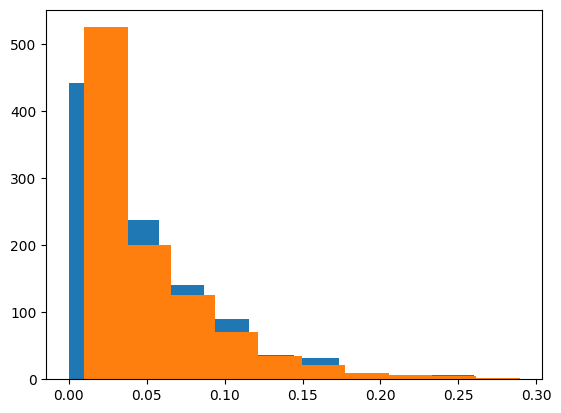

In [5]:
beta = rng.beta(1, 20, size=1000)
plt.hist(beta);
beta_adj = np.array([0.01 if beta_j < 0.01 else beta_j for beta_j in beta])
plt.hist(beta_adj);

In [243]:
#findTrunc(50, 50, beta_adj, 10**-6)
truncationMatrix = preComputeTruncation(10, 10, beta_adj, 10**-6)

In [244]:
truncationMatrix

array([[(599, 599), (695, 696), (766, 768), (824, 827), (871, 875),
        (910, 915), (941, 947), (965, 972), (982, 990), (1, 10)],
       [(696, 695), (807, 807), (891, 892), (960, 962), (1018, 1021),
        (1068, 1072), (1110, 1115), (1146, 1152), (1176, 1183), (2, 10)],
       [(768, 766), (892, 891), (986, 986), (1064, 1065), (1131, 1133),
        (1189, 1192), (1240, 1244), (1284, 1289), (3, 9), (3, 10)],
       [(827, 824), (962, 960), (1065, 1064), (1151, 1151), (1225, 1226),
        (1291, 1293), (1348, 1351), (4, 8), (4, 9), (4, 10)],
       [(875, 871), (1021, 1018), (1133, 1131), (1226, 1225),
        (1307, 1307), (1379, 1380), (5, 7), (5, 8), (5, 9), (5, 10)],
       [(915, 910), (1072, 1068), (1192, 1189), (1293, 1291),
        (1380, 1379), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10)],
       [(947, 941), (1115, 1110), (1244, 1240), (1351, 1348), (7, 5),
        (7, 6), (7, 7), (7, 8), (7, 9), (7, 10)],
       [(972, 965), (1152, 1146), (1289, 1284), (8, 4), (8, 5), (8, 

# Dataset simulation

In [6]:
def realistic_dataset_simulation(beta, gene_pairs=100, cells=1000):
    '''
    Simulate parameters for each pair of genes, then simulate counts from each
    cell using the parameters and a fixed interaction strength (relative to parameters)

    beta: capture efficiency vector of length 'cells'
    '''

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # for each gene
    for i in range(gene_pairs):

        # Simulate reaction rate parameters 
        
        # sample rates from log-uniform distribution for both genes
        '''reduce range from real estimates for efficiency'''
        log_k_tx_beta_1 = rng.uniform(-3, 1.5) # 2 to 1.5
        log_k_tx_beta_2 = rng.uniform(-3, 1.5)
        log_k_deg_1 = rng.uniform(-1, 0) # -1.5 to -1
        log_k_deg_2 = rng.uniform(-1, 0)

        # exponentiate and scale
        k_tx_1 = (10 ** log_k_tx_beta_1) / np.mean(beta)
        k_tx_2 = (10 ** log_k_tx_beta_2) / np.mean(beta)
        k_deg_1 = 10 ** log_k_deg_1
        k_deg_2 = 10 ** log_k_deg_2

        # set interaction strength relative to other parameters
        k_reg = 10 * k_deg_2

        # store parameters
        params_df.iloc[i] = [k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # sample from stationary distribution
        sample = simulation_B(params, cells, beta, tmax=100, ts=10)

        # store counts
        counts_df.iloc[i] = sample['OB']

    return {'params_df': params_df, 'counts_df': counts_df}

## Fixed capture efficiency

In [251]:
# dataset of cells with high capture efficiency
beta_high = np.array([1.0 for j in range(1000)])
datasets_high = realistic_dataset_simulation(beta_high, gene_pairs=100, cells=1000)

In [253]:
# dataset of cells with medium capture efficiency
beta_med = np.array([0.5 for j in range(1000)])
datasets_med = realistic_dataset_simulation(beta_med, gene_pairs=100, cells=1000)

In [254]:
# dataset of cells with low capture efficiency
beta_low = np.array([0.06 for j in range(1000)])
datasets_low = realistic_dataset_simulation(beta_low, gene_pairs=100, cells=1000)

In [ ]:
#datasets_high['params_df'].to_csv("./Realistic-Data/params_high.csv")
#datasets_high['counts_df'].to_csv("./Realistic-Data/counts_high.csv")
#datasets_med['params_df'].to_csv("./Realistic-Data/params_med.csv")
#datasets_med['counts_df'].to_csv("./Realistic-Data/counts_med.csv")
#datasets_low['params_df'].to_csv("./Realistic-Data/params_low.csv")
#datasets_low['counts_df'].to_csv("./Realistic-Data/counts_low.csv")

## Sampled capture efficiency

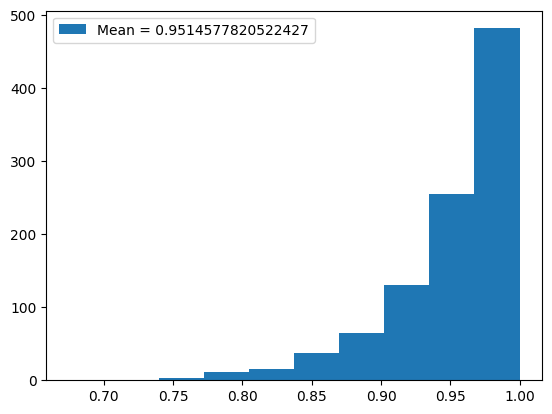

In [8]:
beta_high_sampled = rng.beta(20, 1, size=1000)
plt.hist(beta_high_sampled, label=f"Mean = {beta_high_sampled.mean()}");
plt.legend()

In [19]:
# dataset of cells with sampled high capture efficiency
datasets_high_sampled = realistic_dataset_simulation(beta_high_sampled, gene_pairs=100, cells=1000)

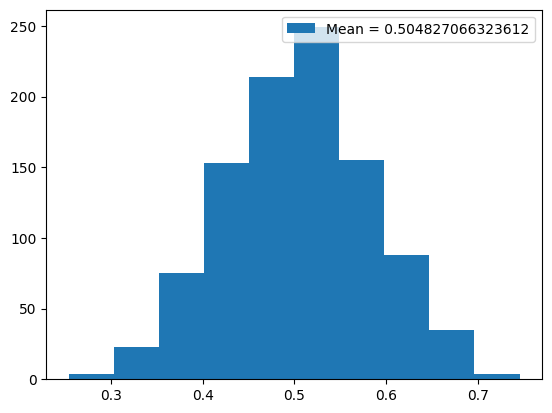

In [9]:
beta_med_sampled = rng.beta(20, 20, size=1000)
plt.hist(beta_med_sampled, label=f"Mean = {beta_med_sampled.mean()}");
plt.legend()

In [20]:
# dataset of cells with sampled med capture efficiency
datasets_med_sampled = realistic_dataset_simulation(beta_med_sampled, gene_pairs=100, cells=1000)

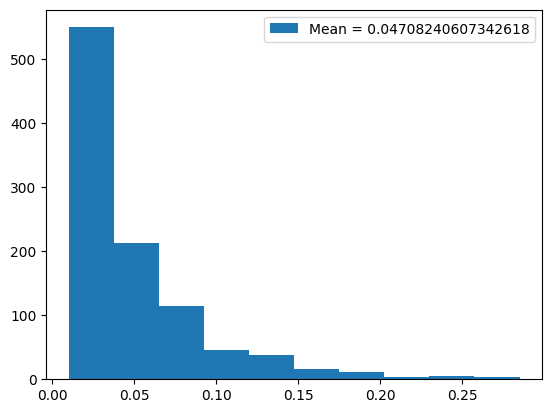

In [11]:
beta_low_sampled = rng.beta(1, 20, size=1000)
beta_low_sampled[beta_low_sampled < 0.01] = 0.01
plt.hist(beta_low_sampled, label=f"Mean = {beta_low_sampled.mean()}");
plt.legend()

In [21]:
# dataset of cells with sampled low capture efficiency
datasets_low_sampled = realistic_dataset_simulation(beta_low_sampled, gene_pairs=100, cells=1000)

In [ ]:
#datasets_high_sampled['params_df'].to_csv("./Realistic-Data/params_high_sampled.csv")
#datasets_high_sampled['counts_df'].to_csv("./Realistic-Data/counts_high_sampled.csv")
#datasets_med_sampled['params_df'].to_csv("./Realistic-Data/params_med_sampled.csv")
#datasets_med_sampled['counts_df'].to_csv("./Realistic-Data/counts_med_sampled.csv")
#datasets_low_sampled['params_df'].to_csv("./Realistic-Data/params_low_sampled.csv")
#datasets_low_sampled['counts_df'].to_csv("./Realistic-Data/counts_low_sampled.csv")

In [ ]:
# save capture efficiencies
#np.savetxt("./Realistic-Data/beta_high_sampled.csv", beta_high_sampled, delimiter=",")
#np.savetxt("./Realistic-Data/beta_med_sampled.csv", beta_med_sampled, delimiter=",")
#np.savetxt("./Realistic-Data/beta_low_sampled.csv", beta_low_sampled, delimiter=",")

# Simulation (revised): reduced ranges and sampled interaction

The method of sampling rates for a pair of interacting genes used to simulate the above datasets is:

- sample all 4 rates (transcription and degradation) from log-uniform distributions
- sample capture efficiency per cell / fix to mean
- choose $k_{reg}$ relative to $k_{deg_{2}}$

However, even with slightly reduced ranges of tx. and deg. rates, the majority of samples were dominated by one gene with the other having almost all counts = 0. This is because the pair of genes are likely to have significantly different mean counts (if they were independent) e.g. $\frac{k_{tx}}{k_{deg}} = 10$ vs $0.1$ when sampling randomly, and the strong interaction (relative) means the more productive gene keeps the other at 0 counts due to the regulation reaction.

To address this we investigate reducing the range of rates from (-3, 2) and (-1.5, 0) to ~(-1, 1.5) and ~(-1, 0), and sampling (log) interaction strength from e.g. (-2, 2) to produce a range of values:

k_tx_1 = 1.5372396350029551
k_tx_2 = 0.12874047131074035
k_deg_1 = 0.3595737559413028
k_deg_2 = 0.11747325066043805
k_reg = 0.1911932932594883


Text(0, 0.1, 'Mean beta = 1.0')

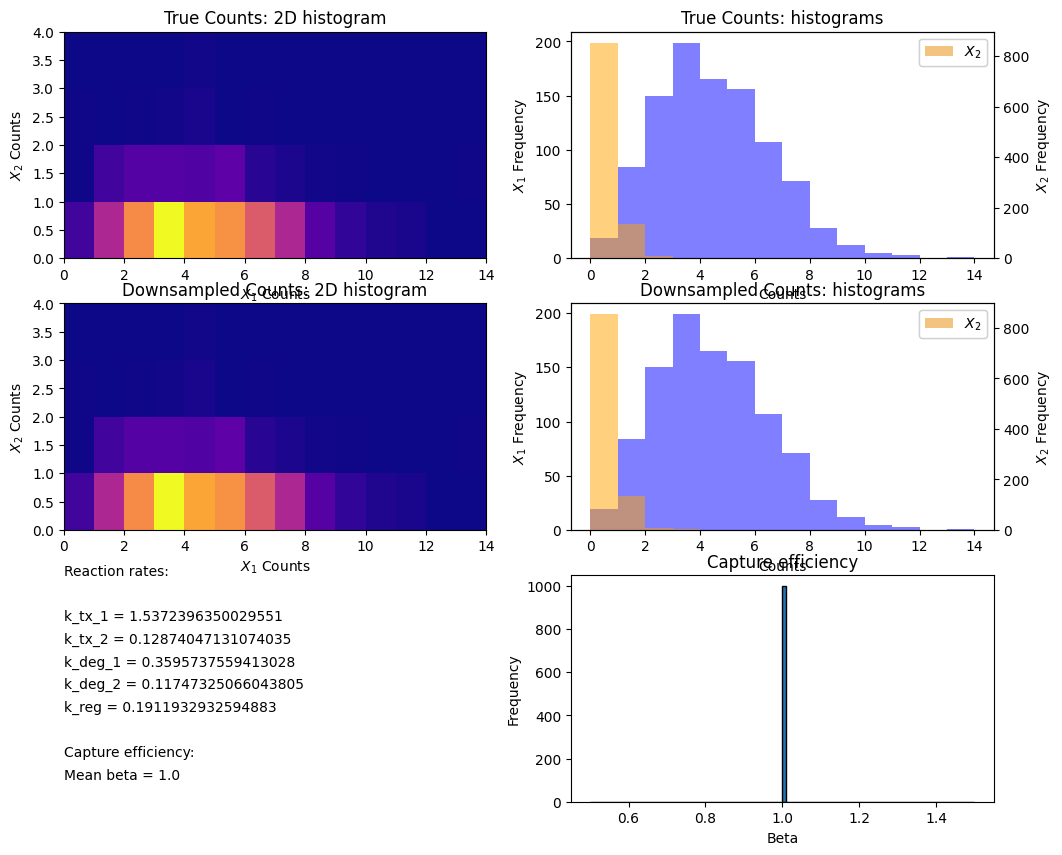

In [43]:
# sample size (cells)
n = 1000

# simulation parameters
params = {}

# mean capture efficiency
mean_beta = 1.0

# sample rates from log-uniform distribution for both genes
log_k_tx_beta_1 = rng.uniform(-1, 1.5)
log_k_tx_beta_2 = rng.uniform(-1, 1.5)
log_k_deg_1 = rng.uniform(-1, 0)
log_k_deg_2 = rng.uniform(-1, 0)
log_k_reg = rng.uniform(-2, 2)

# exponentiate and scale
params['k_tx_1'] = (10 ** log_k_tx_beta_1) / mean_beta
params['k_tx_2'] = (10 ** log_k_tx_beta_2) / mean_beta
params['k_deg_1'] = 10 ** log_k_deg_1
params['k_deg_2'] = 10 ** log_k_deg_2
params['k_reg'] = 10 ** log_k_reg

for key, val in params.items():
    print(f"{key} = {val}")

# sample counts from stationary distribution
sample = simulationBDInt(params, n=n, tmax=100, ts=10) 

x1_sample = [x[0] for x in sample]
x2_sample = [x[1] for x in sample]

# plot

# 2D histogram of true counts
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs[0, 0].hist2d(x1_sample, x2_sample, bins=[range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2)],
                 cmap='plasma')
axs[0, 0].set_xlabel(r"$X_{1}$ Counts")
axs[0, 0].set_ylabel(r"$X_{2}$ Counts")
axs[0, 0].set_title("True Counts: 2D histogram")

# separate histograms of observed counts
axs[0, 1].hist(x1_sample, bins=range(int(np.min(x1_sample)), int(np.max(x1_sample)) + 2), alpha=0.5, color="blue", label=r"$X_{1}$");
axs01_twin = axs[0, 1].twinx()
axs01_twin.hist(x2_sample, bins=range(int(np.min(x2_sample)), int(np.max(x2_sample)) + 2), alpha=0.5, color="orange", label=r"$X_{2}$");
axs[0, 1].set_xlabel("Counts")
axs[0, 1].set_ylabel(r"$X_{1}$ Frequency")
axs01_twin.set_ylabel(r"$X_{2}$ Frequency")
axs[0, 1].set_title("True Counts: histograms")
axs[0, 1].legend()
axs01_twin.legend()

# sample capture efficiency from beta distribution
#beta = rng.beta(a=1, b=20, size=n)

# fix capture efficiency of each cell equal to mean
beta = np.array([mean_beta for j in range(1000)])

# downsample counts using capture efficiency
x1_sample_downsampled = rng.binomial(x1_sample, beta).tolist()
x2_sample_downsampled = rng.binomial(x2_sample, beta).tolist()
sample_downsampled = list(zip(x1_sample_downsampled, x2_sample_downsampled))

# 2D histogram of downsampled counts
axs[1, 0].hist2d(x1_sample_downsampled, x2_sample_downsampled, bins=[range(int(np.min(x1_sample_downsampled)), int(np.max(x1_sample_downsampled)) + 2), range(int(np.min(x2_sample_downsampled)), int(np.max(x2_sample_downsampled)) + 2)],
                 cmap='plasma')
axs[1, 0].set_xlabel(r"$X_{1}$ Counts")
axs[1, 0].set_ylabel(r"$X_{2}$ Counts")
axs[1, 0].set_title("Downsampled Counts: 2D histogram")

# separate histograms of downsampled counts
axs[1, 1].hist(x1_sample_downsampled, bins=range(int(np.min(x1_sample_downsampled)), int(np.max(x1_sample_downsampled)) + 2), alpha=0.5, color="blue", label=r"$X_{1}$");
axs11_twin = axs[1, 1].twinx()
axs11_twin.hist(x2_sample_downsampled, bins=range(int(np.min(x2_sample_downsampled)), int(np.max(x2_sample_downsampled)) + 2), alpha=0.5, color="orange", label=r"$X_{2}$");
axs[1, 1].set_xlabel("Counts")
axs[1, 1].set_ylabel(r"$X_{1}$ Frequency")
axs11_twin.set_ylabel(r"$X_{2}$ Frequency")
axs[1, 1].set_title("Downsampled Counts: histograms")
axs[1, 1].legend()
axs11_twin.legend()

# capture efficiency
axs[2, 1].hist(beta, bins=100, edgecolor='black');
axs[2, 1].set_xlabel("Beta")
axs[2, 1].set_ylabel("Frequency")
axs[2, 1].set_title("Capture efficiency")

# display info
axs[2, 0].axis('off')
axs[2, 0].text(0, 1.0, f"Reaction rates:")
axs[2, 0].text(0, 0.8, f"k_tx_1 = {params['k_tx_1']}")
axs[2, 0].text(0, 0.7, f"k_tx_2 = {params['k_tx_2']}")
axs[2, 0].text(0, 0.6, f"k_deg_1 = {params['k_deg_1']}")
axs[2, 0].text(0, 0.5, f"k_deg_2 = {params['k_deg_2']}")
axs[2, 0].text(0, 0.4, f"k_reg = {params['k_reg']}")
axs[2, 0].text(0, 0.2, f"Capture efficiency:")
axs[2, 0].text(0, 0.1, f"Mean beta = {mean_beta}")
#axs[2, 0].text(0, 0.1, f"Alpha = 1")
#axs[2, 0].text(0, 0.0, f"Beta = 20")

# Dataset simulation (revised)

In [87]:
def realistic_dataset_simulation_revised(beta, gene_pairs=100, cells=1000, interaction=True):
    '''
    Sample parameters for each pair of genes, then simulate counts from each
    cell using the parameters and a sampled interaction strength

    beta: capture efficiency vector of length 'cells'
    interaction: toggle for sampling interaction parameter / fixing to 0
    '''

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # for each gene
    for i in range(gene_pairs):

        # Simulate reaction rate parameters 
        
        # sample rates from log-uniform distribution for both genes
        log_k_tx_beta_1 = rng.uniform(-1, 1.5)
        log_k_tx_beta_2 = rng.uniform(-1, 1.5)
        log_k_deg_1 = rng.uniform(-1, 0)
        log_k_deg_2 = rng.uniform(-1, 0)
        if interaction: log_k_reg = rng.uniform(-2, 2)

        # exponentiate and scale
        k_tx_1 = (10 ** log_k_tx_beta_1) / np.mean(beta)
        k_tx_2 = (10 ** log_k_tx_beta_2) / np.mean(beta)
        k_deg_1 = 10 ** log_k_deg_1
        k_deg_2 = 10 ** log_k_deg_2
        if interaction:
            k_reg = 10 ** log_k_reg
        else:
            k_reg = 0

        # store parameters
        params_df.iloc[i] = [k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # sample from stationary distribution
        sample = simulation_B(params, cells, beta, tmax=100, ts=10)

        # store counts
        counts_df.iloc[i] = sample['OB']

    return {'params_df': params_df, 'counts_df': counts_df}

### Fixed capture efficiency

In [30]:
# dataset of cells with high capture efficiency
beta_high = np.array([1.0 for j in range(1000)])
datasets_high_revised = realistic_dataset_simulation_revised(beta_high, gene_pairs=100, cells=1000)

Sample new set with doubled transcription rates to reduce proportion of gene pairs with one gene having (almost) all 0 counts

In [85]:
# dataset of cells with high capture efficiency
beta_high = np.array([1.0 for j in range(1000)])
datasets_high_revised_new = realistic_dataset_simulation_revised(beta_high, gene_pairs=100, cells=1000)

In [31]:
# dataset of cells with med capture efficiency
beta_med = np.array([0.5 for j in range(1000)])
datasets_med_revised = realistic_dataset_simulation_revised(beta_med, gene_pairs=100, cells=1000)

In [ ]:
# dataset of cells with low capture efficiency
#beta_low = np.array([0.06 for j in range(1000)])
#datasets_low_revised = realistic_dataset_simulation_revised(beta_low, gene_pairs=100, cells=1000)

In [ ]:
#datasets_high_revised['params_df'].to_csv("./Realistic-Data/params_high_revised.csv")
#datasets_high_revised['counts_df'].to_csv("./Realistic-Data/counts_high_revised.csv")
#datasets_med_revised['params_df'].to_csv("./Realistic-Data/params_med_revised.csv")
#datasets_med_revised['counts_df'].to_csv("./Realistic-Data/counts_med_revised.csv")
#datasets_low_revised['params_df'].to_csv("./Realistic-Data/params_low_revised.csv")
#datasets_low_revised['counts_df'].to_csv("./Realistic-Data/counts_low_revised.csv")

Store new high set

In [ ]:
#datasets_high_revised_new['params_df'].to_csv("./Realistic-Data/params_high_revised_new.csv")
#datasets_high_revised_new['counts_df'].to_csv("./Realistic-Data/counts_high_revised_new.csv")

#### No interaction

In [37]:
# dataset of cells with high capture efficiency: no interaction
beta_high = np.array([1.0 for j in range(1000)])
datasets_high_revised_noInt = realistic_dataset_simulation_revised(beta_high, gene_pairs=100, cells=1000, interaction=False)

In [38]:
# dataset of cells with med capture efficiency: no interaction
beta_med = np.array([0.5 for j in range(1000)])
datasets_med_revised_noInt = realistic_dataset_simulation_revised(beta_med, gene_pairs=100, cells=1000, interaction=False)

In [ ]:
#datasets_high_revised_noInt['params_df'].to_csv("./Realistic-Data/params_high_revised_noInt.csv")
#datasets_high_revised_noInt['counts_df'].to_csv("./Realistic-Data/counts_high_revised_noInt.csv")
#datasets_med_revised_noInt['params_df'].to_csv("./Realistic-Data/params_med_revised_noInt.csv")
#datasets_med_revised_noInt['counts_df'].to_csv("./Realistic-Data/counts_med_revised_noInt.csv")

# Appendix

## Invariance under parameter scaling

The stationary distribution of the Stochastic Reaction Networks being simulated is invariant under scaling of all reaction rate parameters by a constant multiple, as it does not affect the transition probabilities (and so the jump chain) and scales holding times equally for all states, so the proportion of time spent in each state remains the same (and so the stationary distribution).

For this reason, the exact values of the reaction rate parameters are not identifiable given only information about the stationary distribution, but only their values relative to each other. So we fix one parameter (usually a degradation rate to 1) when performing inference. To compare the true parameter values to the results we should scale the true values to match this (e.g. divide all by the true value of the degradation rate that was fixed to 1 during inference)

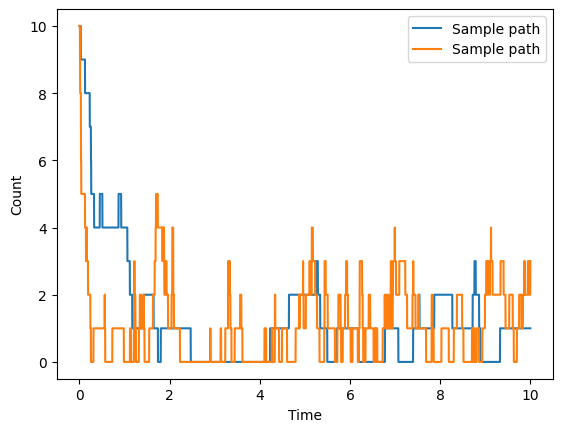

In [151]:
# parameter sets: scaled by a multiple
params_BD_1 = {
    'k_tx': 1,
    'k_deg': 1
}

params_BD_2 = {
    'k_tx': 10,
    'k_deg': 10
}

# plot sample paths
sample_BD_1 = simulationBD(params_BD_1, n=1, tmax=10, ts=10, plot=True, plotShow=False, initial_state=10)
sample_BD_2 = simulationBD(params_BD_2, n=1, tmax=10, ts=10, plot=True, initial_state=10)

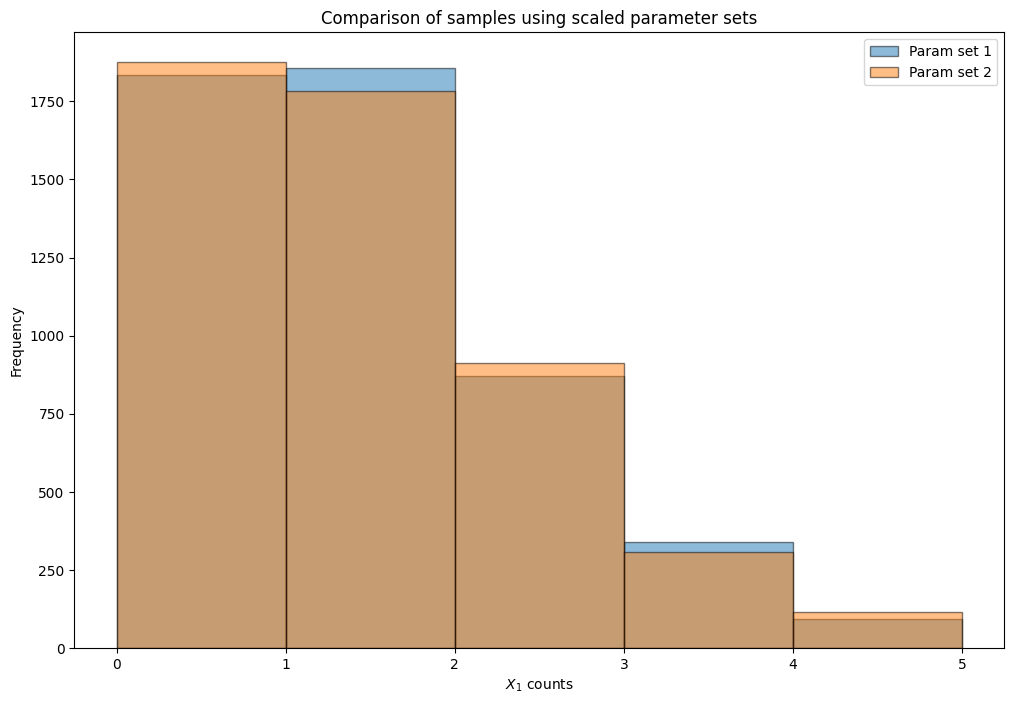

In [152]:
# take large samples using both parameter sets
sample_BD_1 = simulationBD(params_BD_1, n=5000, tmax=100, ts=10)
sample_BD_2 = simulationBD(params_BD_2, n=5000, tmax=100, ts=10)

# plot sample histograms
fig = plt.figure(figsize=(12, 8))
plt.hist(sample_BD_1, bins=range(6), alpha=0.5, edgecolor='black', label="Param set 1");
plt.hist(sample_BD_2, bins=range(6), alpha=0.5, edgecolor='black', label="Param set 2");
plt.xlabel(r"$X_{1}$ counts")
plt.ylabel("Frequency")
plt.title("Comparison of samples using scaled parameter sets")
plt.legend()
plt.show()

As shown by the sample paths, multplying all rates by 10 means the orange sample path has much shorter holding times in each state, jumping around much more than the blue path.

However, as shown by the histograms, the distribution of samples (assumed from the stationary distribution) is the same for both parameter sets.

This shows that our samples, and results based on them, will be invariant under scaling all parameters.